In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

# **AA_utils**

In [2]:
def graficar_curva_elbow(X, N, GMM=False):
    plt.figure()
    Nc = range(1, N+1)
    if (GMM):
        kmeans = [GaussianMixture(n_components=i) for i in Nc]
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    if (GMM):
        score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
        scoreBIC = [kmeans[i].fit(X).bic(X) for i in range(len(kmeans))]
    else:
        score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    plt.plot(Nc, score, 'b')
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Curve')
    plt.grid()
    if (GMM):
        plt.ylabel('log(verosimilitud)')
        plt.figure()
        plt.plot(Nc, scoreBIC, 'r--')
        plt.title('BIC Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Bayesian information criterion')
        plt.grid()
    else:
        plt.ylabel('Promedio de sumas de distancias')
    plt.show()


# índice Silhouette
def graficar_indice_silhouette(X, N, GMM=False):

    plt.figure()
    Nc = range(2, N+1)
    if (GMM):
        # kmeans = [GaussianMixture(n_components=i) for i in Nc]
        print("Sin terminar silhouette para GMM")
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, kmeans[i].fit(X).predict(X))
             for i in range(len(kmeans))]
    score
    plt.plot(Nc, score)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Promedio de índice silhouette')
    plt.title('Índice silhouette para distintos K')
    plt.grid()
    plt.show()


def graficar_indice_silhouette_k(X, n_clusters):

    # Compute the silhouette scores for each sample
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plt.figure()
    ax1 = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot para cada Cluster.")
    ax1.set_xlabel("Coeficientes silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


def graficar_GMM(data, modelo, labels=False, probs=False):
    # display predicted scores by the model as a contour plot
    cant_points = 200
    x = np.linspace(min(data[:, 0])*0.9, max(data[:, 0])*1.1, cant_points)
    y = np.linspace(min(data[:, 1])*0.9, max(data[:, 1])*1.1, cant_points)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    if (probs):
        Z = np.exp(modelo.score_samples(XX))
    else:
        Z = -modelo.score_samples(XX)
    Z = Z.reshape(X.shape)

    centros = modelo.means_
    cant_gauss = centros.shape[0]
    if (probs):
        CS = plt.contour(X, Y, Z, levels=np.linspace(
            0, np.max(Z), cant_gauss*10),  linewidths=2)
        plt.title('Probabilidades de la GMM')
    else:
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                         levels=np.logspace(0, 3, 20),  linewidths=2)
        plt.title('Negative log-likelihood de la GMM')
    plt.colorbar(CS, shrink=0.5)
    if (labels):
        etiq = modelo.predict(data)
        plt.scatter(data[:, 0], data[:, 1], s=30, c=etiq)
    else:
        plt.scatter(data[:, 0], data[:, 1], s=30)
    plt.scatter(centros[:, 0], centros[:, 1],
                marker='o', c='red', s=100, alpha=0.8)
    plt.grid()
    plt.axis('tight')
    plt.show()


def visualizar_clustering_2D(data, labels, centers):
    values = data.to_numpy()
    plt.figure()
    plt.scatter(values[:, 0], values[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='*', c='red', s=600, alpha=0.8)
    plt.show()


def graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_):
    plt.figure()
    noise_maks = labels == -1
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # plot RUIDO
    x = data[noise_maks]  # datos RUIDO (outliers)
    plt.scatter(x[:, 0], x[:, 1], color=[0.2, 0.2, 0.2, 0.8],
                s=20, cmap='viridis', label='ruido', marker='x')
    # plot datos CORE en clusters
    x = data[~noise_maks & core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks &
                core_samples_mask], s=30, cmap='viridis', label='Cores')
    # plot datos NO CORE en clusters
    x = data[~noise_maks & ~core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks & ~core_samples_mask],
                s=20, cmap='viridis', label='Borders', marker='D')

    title = "eps= {}, min_samples= {}, #clusters= {}".format(
        EPS, MINSAM, n_clusters_)
    plt.title(title)
    plt.legend()
    plt.show()

# **Zoo**

Como comentario el archivo venía en formato xlsx y decidí, antes de cargarlo al GitHug, transformarlo en csv para poder enlazar el Colab con el GitHub dado que para archivos xlsx no pude hacerlo.

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/zoo.csv") 

# **A. Quite las columnas animal y Clase.**

Realizo una vista del Data Frame, previa eliminación de columnas requeridas en la consigna para observar su nombre.

In [4]:
data.head()

,animal,Tiene_Pelo,Tiene_Plumas,Nace_de_huevo,Toma_Leche,Vuela,Acuático,Depredador,Dentado,Vertebrado,Respira,Venenoso,Tiene_Aletas,Cant_Patas,Tiene_Cola,Domestico,Tamaño_Gato,Clase
0,oso_hormiguero,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,Mamifero
1,antilope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,Mamifero
2,robalo,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,Pez
3,oso,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,Mamifero
4,jabali,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,Mamifero


Elimino las columnas animal y clase

In [5]:
df = data.drop(["animal", "Clase"], axis=1)

Compruebo que se hayan eliminado correctamente

In [6]:
df.head(10)

,Tiene_Pelo,Tiene_Plumas,Nace_de_huevo,Toma_Leche,Vuela,Acuático,Depredador,Dentado,Vertebrado,Respira,Venenoso,Tiene_Aletas,Cant_Patas,Tiene_Cola,Domestico,Tamaño_Gato
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1
5,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
6,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1
7,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0
8,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
9,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,0


# **B. ¿Como puede interpretar los centroides de variables que eran binarias?**

Entiendo que puedo utilizar tanto el modelo Kmeans como el de GMM, por lo tanto, optaré por el modelo GMM

**Modelo GMM**

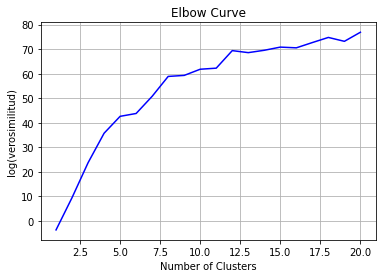

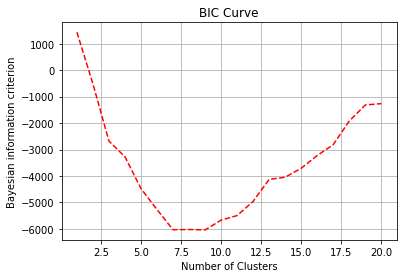

In [7]:
graficar_curva_elbow(df, 20, GMM = 1)

**Elijo un k = 5**

In [8]:
k = 5

Defino la variable a normalizar

In [9]:
df_norm_GMM = df

Normalizo

In [10]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler_GMM = StandardScaler()
    scaler_GMM.fit(df_norm_GMM)
    df_norm_GMM = scaler_GMM.transform(df_norm_GMM)

Armo el modelo GMM

In [11]:
modelo = GaussianMixture(n_components=k, verbose=True, covariance_type='full')
modelo = modelo.fit(df_norm_GMM)
centers = modelo.means_
df_norm_GMM = pd.DataFrame(scaler_GMM.inverse_transform(centers), columns=df.columns)
df_norm_GMM.to_excel("df_norm_GMM.xlsx")

Initialization 0
Initialization converged: True


**MODELO GMM NORMALIZADO CON k = 5**

In [12]:
df_norm_GMM = pd.read_excel("/content/df_norm_GMM.xlsx") 
df_norm_GMM = df_norm_GMM.transpose()
round(df_norm_GMM.head(20))

,0,1,2,3,4
Unnamed: 0,0.0,1.0,2.0,3.0,4.0
Tiene_Pelo,1.0,0.0,0.0,0.0,0.0
Tiene_Plumas,-0.0,1.0,0.0,0.0,0.0
Nace_de_huevo,0.0,1.0,1.0,1.0,1.0
Toma_Leche,1.0,0.0,0.0,0.0,0.0
Vuela,0.0,1.0,0.0,0.0,0.0
Acuático,0.0,0.0,1.0,1.0,0.0
Depredador,1.0,0.0,1.0,1.0,0.0
Dentado,1.0,0.0,1.0,1.0,0.0
Vertebrado,1.0,1.0,1.0,1.0,0.0


La **clasificación binaria** es la tarea de clasificar los elementos de un conjunto en dos grupos sobre la base de una regla de clasificación (en este caso: en 0 o en 1, salvo la cantidad de patas). Esta clasificación permite saber con presición en que clasificación se encuentra.

Por el lado de la interpretación bajo el modelo de normalización de GMM se necesita redondear a 0 decimales los datos obtenidos para determinar a qué categoría pertenece, algo que no comprendo si está del todo bien debido a que lo estoy forzando a que se aproxime tanto al 0 como al 1 cuando en verdad el modelo no los está dando con el 100%. Es por esto que debajo dejo los valores con 2 decimales para que se termine de entender lo que acabo de explicar:

In [13]:
round(df_norm_GMM.head(20), 2)

,0,1,2,3,4
Unnamed: 0,0.00,1.00,2.00,3.00,4.00
Tiene_Pelo,1.00,0.00,0.00,0.00,0.22
Tiene_Plumas,-0.00,0.95,0.00,0.00,0.00
Nace_de_huevo,0.03,1.00,0.81,1.00,0.94
Toma_Leche,1.00,0.00,0.12,0.00,0.00
Vuela,0.05,0.76,0.00,0.00,0.33
Acuático,0.10,0.29,1.00,0.57,0.33
Depredador,0.51,0.43,0.75,0.86,0.50
Dentado,0.97,0.00,1.00,1.00,0.00
Vertebrado,1.00,1.00,1.00,1.00,0.00


# **C. Ver como se corresponden los clusters encontrados con la columna Clase.**

Observo la cantidad de clases tengo en el Data Frame

In [14]:
clase = data["Clase"].unique()
clase

array(['Mamifero', 'Pez', 'Ave', 'Invertebrado', 'Insecto', 'Anfibio',
       'Reptil'], dtype=object)

In [15]:
data["Clase"].value_counts()

Mamifero        41
Ave             20
Pez             13
Invertebrado    10
Insecto          8
Reptil           5
Anfibio          4
Name: Clase, dtype: int64

Cuento cúantas clases tengo para definir k e interpretar si con este modelo logro representar los tipos de clases del DataFrame

In [16]:
clase.shape

(7,)

In [17]:
k_clase = 7

Defino la variable a normalizar

In [18]:
df_norm_GMM_2 = df

Normalizo

In [19]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler_GMM_2 = StandardScaler()
    scaler_GMM_2.fit(df_norm_GMM_2)
    df_norm_GMM_2 = scaler_GMM_2.transform(df_norm_GMM_2)

Armo el modelo GMM

In [20]:
modelo_2 = GaussianMixture(n_components=k_clase, verbose=True, covariance_type='full')
modelo_2 = modelo_2.fit(df_norm_GMM_2)
centers_2 = modelo_2.means_
df_norm_GMM_2 = pd.DataFrame(scaler_GMM.inverse_transform(centers_2), columns=df.columns)
df_norm_GMM_2.to_excel("df_norm_GMM_2.xlsx")

Initialization 0
Initialization converged: True


**MODELO GMM NORMALIZADO CON k = 7**

In [21]:
df_norm_GMM = pd.read_excel("/content/df_norm_GMM_2.xlsx") 
round(df_norm_GMM.head(20), 2)

,Unnamed: 0,Tiene_Pelo,Tiene_Plumas,Nace_de_huevo,Toma_Leche,Vuela,Acuático,Depredador,Dentado,Vertebrado,Respira,Venenoso,Tiene_Aletas,Cant_Patas,Tiene_Cola,Domestico,Tamaño_Gato
0,0,1.00,-0.00,0.03,1.00,0.05,0.10,0.51,0.97,1.00,1.00,0.00,0.05,3.54,0.85,0.21,0.77
1,1,0.00,0.00,0.78,0.00,0.00,0.56,0.89,0.89,0.89,0.89,0.44,0.00,3.11,0.67,0.00,0.00
2,2,0.25,0.75,1.00,0.00,1.00,0.00,0.00,0.00,0.75,1.00,0.25,0.00,3.00,0.75,1.00,0.00
3,3,0.00,0.00,0.87,0.13,-0.00,1.00,0.73,1.00,1.00,0.13,0.07,1.00,0.00,1.00,0.07,0.40
4,4,0.19,0.00,1.00,0.00,0.31,0.38,0.50,0.00,0.00,0.56,0.12,0.00,4.44,0.00,0.00,0.06
5,5,0.00,0.67,1.00,0.00,0.67,0.00,0.33,0.00,1.00,1.00,0.00,0.00,2.67,1.00,0.00,1.00
6,6,0.00,1.00,1.00,0.00,0.73,0.40,0.53,0.00,1.00,1.00,0.00,0.00,2.00,1.00,0.00,0.27


**Se puede observar que algunas variables fueron bien reconocidas como por ejemplo:**
*   **Aquellos animales que tienen plumas no tienen pelo**
*   **Si tiene plumas vuela**
*   **Si es acuatico, tiene aletas y no posee cola**
*   **Al igual que en el DataFrame original, ninguno (o en su gran mayoría) son domésticos ni venenosos.**

**Con esto concluyo en que es un buen modelo.**

In [22]:
round(pd.pivot_table(data, index =["Clase"]), 2)

,Acuático,Cant_Patas,Dentado,Depredador,Domestico,Nace_de_huevo,Respira,Tamaño_Gato,Tiene_Aletas,Tiene_Cola,Tiene_Pelo,Tiene_Plumas,Toma_Leche,Venenoso,Vertebrado,Vuela
Clase,,,,,,,,,,,,,,,,
Anfibio,1.00,4.00,1.00,0.75,0.00,1.00,1.0,0.00,0.0,0.25,0.00,0,0,0.25,1,0.00
Ave,0.30,2.00,0.00,0.45,0.15,1.00,1.0,0.30,0.0,1.00,0.00,1,0,0.00,1,0.80
Insecto,0.00,6.00,0.00,0.12,0.12,1.00,1.0,0.00,0.0,0.00,0.50,0,0,0.25,0,0.75
Invertebrado,0.60,3.70,0.00,0.80,0.00,0.90,0.3,0.10,0.0,0.10,0.00,0,0,0.20,0,0.00
Mamifero,0.15,3.37,0.98,0.54,0.20,0.02,1.0,0.78,0.1,0.85,0.95,0,1,0.00,1,0.05
Pez,1.00,0.00,1.00,0.69,0.08,1.00,0.0,0.31,1.0,1.00,0.00,0,0,0.08,1,0.00
Reptil,0.20,1.60,0.80,0.80,0.00,0.80,0.8,0.20,0.0,1.00,0.00,0,0,0.40,1,0.00
